# Analysis of the Human Connectome Project (funcional connectome)

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, train_test_split, cross_val_predict
from joblib import Parallel, delayed
from mlxtend.evaluate import permutation_test
sns.set(rc={"figure.figsize":(4, 2)})
sns.set_style("whitegrid")

## Load HCP data

We load functional network matrices (netmats) from the HCP1200-release, as published on connectomeDB: https://db.humanconnectome.org/
Due to licensoing issues, data is not supplied with the repository, but can be downloaded from the ConnectomeDB.
See [hcp_data/readme.md](hcp_data/readme.md) for more details.

In [2]:
# HCP data can be obtained from the connectomeDB
# data is not part of this repository
subjectIDs = pd.read_csv('hcp_data/subjectIDs.txt', header=None)

netmats_pearson = pd.read_csv('hcp_data/netmats1_correlationZ.txt',
                             sep=' ',
                             header=None)
netmats_pearson['ID'] = subjectIDs[0]
netmats_pearson.set_index('ID', drop=True, inplace=True)


netmats_parcor = pd.read_csv('hcp_data/netmats2_partial-correlation.txt',
                             sep=' ',
                             header=None)
netmats_parcor['ID'] = subjectIDs[0]
netmats_parcor.set_index('ID', drop=True, inplace=True)

behavior = pd.read_csv('hcp_data/hcp1200_behavioral_data.csv')
behavior = behavior.set_index('Subject', drop=True)

# convert age to numeric
age = []
for s in behavior['Age']:
    if s == '36+':
        age.append(36)
    else:
        split = s.split(sep='-')
        age.append(np.mean((float(split[0]), float(split[1]))))

behavior['age'] = age
behavior

,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final,age
Subject,,,,,,,,,,,,,,,,,,,,,
100004,S900,Q06,M,22-25,False,0,0,0,0.0,False,...,101.12,86.45,2.0,45.9,107.17,105.31,1.80,0.0,1.80,23.5
100206,S900,Q11,M,26-30,True,1,1,4,100.0,True,...,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84,28.0
100307,Q1,Q01,F,26-30,True,1,1,4,100.0,True,...,101.12,86.45,0.0,38.6,71.69,71.76,1.76,0.0,1.76,28.0
100408,Q3,Q03,M,31-35,True,1,1,4,100.0,True,...,108.79,98.04,2.0,52.6,114.01,113.59,1.76,2.0,1.68,33.0
100610,S900,Q08,M,26-30,True,2,1,4,100.0,True,...,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992774,Q2,Q02,M,31-35,True,2,2,4,100.0,True,...,122.25,111.41,4.0,50.1,107.17,103.55,1.76,0.0,1.76,33.0
993675,S900,Q09,F,26-30,True,2,2,4,100.0,True,...,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76,28.0
994273,S500,Q06,M,26-30,True,1,1,4,100.0,True,...,122.25,111.41,7.0,63.8,110.65,109.73,1.80,1.0,1.76,28.0


# Prepare target variable
We choose fluid intelligence as target.

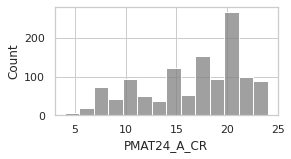

In [3]:
##########################################################
# change these
target = 'PMAT24_A_CR' # fluid intelligence
feature_data = netmats_parcor
##########################################################

sns.histplot(behavior[target], color='gray')

# it's a good practice to use pandas for merging, messing up subject order can be painful
features = feature_data.columns
df = behavior
df = df.merge(feature_data, left_index=True, right_index=True, how='left')
df = df.dropna(subset = [target] + features.values.tolist())
y = df[target].values
X = df[features].values

# Replicability with sample size n=100
Here we train one of the most straightforward models possible: a Ridge regression model.
No hyperparameter optimization, no dimensionality reduction, no feature scaling, we really keep it simple!

We define a workhorse function which:
- randomly samples the discovery and the replication datasets,
- creates cross-validated estimates of predictive performance within the discovery sample
- finalizes the model by fitting it to the whole discovery sample (overfits the discovery but not the replication sample)
- use it to predict the replication sample

We aggregate the results of `n_bootstrap`=100 bootstrap cases (run in parallel).

In [4]:
%%time

random_state = 42

clf = Ridge() # no hyperparameter optimization

n_bootstrap = 100
sample_size = 100

# nested cv
outer_cv = KFold(10, shuffle=True, random_state=random_state)

# loop for bootstrapped discovery and replication sets
def bootstrap_workhorse(random_state):
    X_discovery, X_replication, y_discovery, y_replication = train_test_split(X, y, train_size=sample_size, test_size=sample_size, shuffle=True, random_state=random_state)

    predicted_discovery_cv = cross_val_predict(estimator=clf, X=X_discovery, y=y_discovery, cv=outer_cv, n_jobs=1)
    r_disc_cv = np.corrcoef(predicted_discovery_cv, y_discovery)[0, 1]
    # Finalize on full discovery set
    final_model = clf.fit(X=X_discovery, y=y_discovery)

    # Test on replication set
    predicted_replication = final_model.predict(X=X_replication)
    r_rep = np.corrcoef(predicted_replication, y_replication)[0, 1]

    p_disc_cv = permutation_test(predicted_discovery_cv, y_discovery, method='approximate', num_rounds=10000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)
    p_rep = permutation_test(predicted_replication, y_replication, method='approximate', num_rounds=10000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)

    return r_disc_cv, r_rep, p_disc_cv, p_rep

rng = np.random.default_rng(random_state)
random_sates = rng.integers(np.iinfo(np.int32).max, size=n_bootstrap)

r_discovery_cv, r_replication, p_discovery_cv, p_replication = zip(
    *Parallel(n_jobs=-1)(
    delayed(bootstrap_workhorse)(seed) for seed in random_sates))


CPU times: user 214 ms, sys: 236 ms, total: 450 ms
Wall time: 34.8 s


### Now we plot the Pearson-correlation between predicted and observed, both in case of the discovery and replication sample:

r                                                        p  \
             count      mean       std       min       50%       max  count   
set                                                                           
discovery    100.0  0.204805  0.143074 -0.152600  0.225388  0.497411  100.0   
replication  100.0  0.227487  0.110248 -0.036669  0.218335  0.460480  100.0   

                                                             
                 mean       std     min       50%       max  
set                                                          
discovery    0.129601  0.239205  0.0001  0.013199  0.938006  
replication  0.063309  0.123266  0.0001  0.014599  0.635436

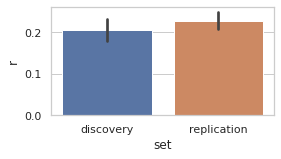

In [5]:
plot_data = pd.DataFrame({
    'r': np.concatenate((r_discovery_cv, r_replication)),
    'p': np.concatenate((p_discovery_cv, p_replication)),
    'set': np.concatenate((np.repeat('discovery', n_bootstrap), np.repeat('replication', n_bootstrap)))
})
sns.barplot(x='set', y='r', data=plot_data)
plot_data.groupby('set').describe(percentiles = [0.5])

### Let's plot the (permutation-based) p-values, too

<AxesSubplot:xlabel='set', ylabel='p'>

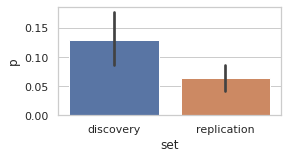

In [6]:
sns.barplot(x='set', y='p', data=plot_data)

### Plot all bootstrap cases: scatterplot of 'in-sample' vs. 'out-of-sample' r.

Text(0.5, 0, 'out-of-sample (r_pred)')

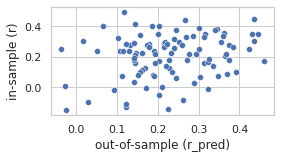

In [7]:
plot_data_wide = pd.DataFrame({
    'r_discovery_cv': r_discovery_cv,
    'r_replication': r_replication,
    'p_discovery_cv': p_discovery_cv,
    'p_replication': p_replication
})
sns.scatterplot(x='r_replication', y='r_discovery_cv', data=plot_data_wide)
plt.ylabel('in-sample (r)')
plt.xlabel('out-of-sample (r_pred)')

## Replicability
We compute replicability as ratio of cases where the replication sample gave significant predictions, given that the discovery sample gave significant predictions.

In [8]:
for alpha in [0.05, 0.01, 0.05, 0.001]:
    plot_data_wide['positive'] = False
    plot_data_wide.loc[plot_data_wide['p_discovery_cv']<alpha,'positive'] = True

    print('Replicability at alpha =', alpha, ':', (plot_data_wide.loc[plot_data_wide['p_discovery_cv']<alpha,'p_replication']<alpha).sum(), '%')

Replicability at alpha = 0.05 : 47 %
Replicability at alpha = 0.01 : 24 %
Replicability at alpha = 0.05 : 47 %
Replicability at alpha = 0.001 : 8 %


------------------------------------------------
# Replicability with n=200
Here we train one of the most straightforward models possible: a Ridge regression model.
No hyperparameter optimization, no dimensionality reduction, no feature scaling, we really keep it simple!

We define a workhorse function which:
- randomly samples the discovery and the replication datasets,
- creates cross-validated estimates of predictive performance within the discovery sample
- finalizes the model by fitting it to the whole discovery sample (overfits the discovery but not the replication sample)
- use it to predict the replication sample

We aggregate the results of `n_bootstrap`=100 bootstrap cases (run in parallel).

In [9]:
%%time

random_state = 42

clf = Ridge() # no hyperparameter optimization

n_bootstrap = 100
sample_size = 200

# nested cv
outer_cv = KFold(10, shuffle=True, random_state=random_state)

# loop for bootstrapped discovery and replication sets
def bootstrap_workhorse(random_state):
    X_discovery, X_replication, y_discovery, y_replication = train_test_split(X, y, train_size=sample_size, test_size=sample_size, shuffle=True, random_state=random_state)

    predicted_discovery_cv = cross_val_predict(estimator=clf, X=X_discovery, y=y_discovery, cv=outer_cv, n_jobs=1)
    r_disc_cv = np.corrcoef(predicted_discovery_cv, y_discovery)[0, 1]
    # Finalize on full discovery set
    final_model = clf.fit(X=X_discovery, y=y_discovery)

    # Test on replication set
    predicted_replication = final_model.predict(X=X_replication)
    r_rep = np.corrcoef(predicted_replication, y_replication)[0, 1]

    p_disc_cv = permutation_test(predicted_discovery_cv, y_discovery, method='approximate', num_rounds=10000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)
    p_rep = permutation_test(predicted_replication, y_replication, method='approximate', num_rounds=10000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)

    return r_disc_cv, r_rep, p_disc_cv, p_rep

rng = np.random.default_rng(random_state)
random_sates = rng.integers(np.iinfo(np.int32).max, size=n_bootstrap)

r_discovery_cv, r_replication, p_discovery_cv, p_replication = zip(
    *Parallel(n_jobs=-1)(
    delayed(bootstrap_workhorse)(seed) for seed in random_sates))


CPU times: user 202 ms, sys: 74 ms, total: 276 ms
Wall time: 37.6 s


### Now we plot the Pearson-correlation between predicted and observed, both in case of the discovery and replication sample:

r                                                       p  \
             count     mean       std       min       50%       max  count   
set                                                                          
discovery    100.0  0.26142  0.096906  0.060414  0.262161  0.479077  100.0   
replication  100.0  0.27988  0.065272  0.113203  0.277469  0.425762  100.0   

                                                            
                 mean       std     min      50%       max  
set                                                         
discovery    0.011861  0.033045  0.0001  0.00020  0.200980  
replication  0.001832  0.007308  0.0001  0.00015  0.052895

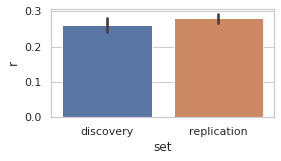

In [10]:
plot_data = pd.DataFrame({
    'r': np.concatenate((r_discovery_cv, r_replication)),
    'p': np.concatenate((p_discovery_cv, p_replication)),
    'set': np.concatenate((np.repeat('discovery', n_bootstrap), np.repeat('replication', n_bootstrap)))
})
sns.barplot(x='set', y='r', data=plot_data)
plot_data.groupby('set').describe(percentiles = [0.5])

### Let's plot the (permutation-based) p-values, too

<AxesSubplot:xlabel='set', ylabel='p'>

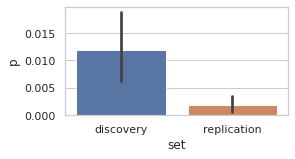

In [11]:
sns.barplot(x='set', y='p', data=plot_data)

### Plot all bootstrap cases: scatterplot of 'in-sample' vs. 'out-of-sample' r.

Text(0.5, 0, 'out-of-sample (r_pred)')

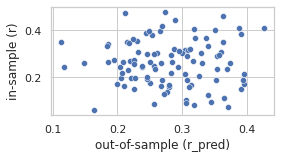

In [12]:
plot_data_wide = pd.DataFrame({
    'r_discovery_cv': r_discovery_cv,
    'r_replication': r_replication,
    'p_discovery_cv': p_discovery_cv,
    'p_replication': p_replication
})
sns.scatterplot(x='r_replication', y='r_discovery_cv', data=plot_data_wide)
plt.ylabel('in-sample (r)')
plt.xlabel('out-of-sample (r_pred)')

## Replicability
We compute replicability as ratio of cases where the replication sample gave significant predictions, given that the discovery sample gave significant predictions.

In [13]:
for alpha in [0.05, 0.01, 0.05, 0.001]:
    plot_data_wide['positive'] = False
    plot_data_wide.loc[plot_data_wide['p_discovery_cv']<alpha,'positive'] = True

    print('Replicability at alpha =', alpha, ':', (plot_data_wide.loc[plot_data_wide['p_discovery_cv']<alpha,'p_replication']<alpha).sum(), '%')

Replicability at alpha = 0.05 : 91 %
Replicability at alpha = 0.01 : 78 %
Replicability at alpha = 0.05 : 91 %
Replicability at alpha = 0.001 : 51 %


---------------------------------------------------------------------------

# Replicability with n=300
Here we train one of the most straightforward models possible: a Ridge regression model.
No hyperparameter optimization, no dimensionality reduction, no feature scaling, we really keep it simple!

We define a workhorse function which:
- randomly samples the discovery and the replication datasets,
- creates cross-validated estimates of predictive performance within the discovery sample
- finalizes the model by fitting it to the whole discovery sample (overfits the discovery but not the replication sample)
- use it to predict the replication sample

We aggregate the results of `n_bootstrap`=100 bootstrap cases (run in parallel).

In [19]:
%%time

random_state = 42

clf = Ridge() # no hyperparameter optimization

n_bootstrap = 100
sample_size = 300

# nested cv
outer_cv = KFold(10, shuffle=True, random_state=random_state)

# loop for bootstrapped discovery and replication sets
def bootstrap_workhorse(random_state):
    X_discovery, X_replication, y_discovery, y_replication = train_test_split(X, y, train_size=sample_size, test_size=sample_size, shuffle=True, random_state=random_state)

    predicted_discovery_cv = cross_val_predict(estimator=clf, X=X_discovery, y=y_discovery, cv=outer_cv, n_jobs=1)
    r_disc_cv = np.corrcoef(predicted_discovery_cv, y_discovery)[0, 1]
    # Finalize on full discovery set
    final_model = clf.fit(X=X_discovery, y=y_discovery)

    # Test on replication set
    predicted_replication = final_model.predict(X=X_replication)
    r_rep = np.corrcoef(predicted_replication, y_replication)[0, 1]

    p_disc_cv = permutation_test(predicted_discovery_cv, y_discovery, method='approximate', num_rounds=10000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)
    p_rep = permutation_test(predicted_replication, y_replication, method='approximate', num_rounds=10000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)

    return r_disc_cv, r_rep, p_disc_cv, p_rep

rng = np.random.default_rng(random_state)
random_sates = rng.integers(np.iinfo(np.int32).max, size=n_bootstrap)

r_discovery_cv, r_replication, p_discovery_cv, p_replication = zip(
    *Parallel(n_jobs=-1)(
    delayed(bootstrap_workhorse)(seed) for seed in random_sates))


CPU times: user 239 ms, sys: 258 ms, total: 497 ms
Wall time: 45.5 s


### Now we plot the Pearson-correlation between predicted and observed, both in case of the discovery and replication sample:

r                                                        p  \
             count      mean       std       min       50%       max  count   
set                                                                           
discovery    100.0  0.282245  0.074809  0.008262  0.290902  0.448418  100.0   
replication  100.0  0.290239  0.055755  0.123305  0.297539  0.405440  100.0   

                                                           
                 mean       std     min     50%       max  
set                                                        
discovery    0.005037  0.044918  0.0001  0.0001  0.449455  
replication  0.000342  0.001728  0.0001  0.0001  0.017098

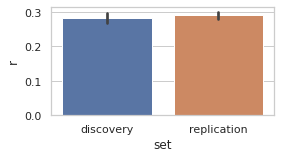

In [20]:
plot_data = pd.DataFrame({
    'r': np.concatenate((r_discovery_cv, r_replication)),
    'p': np.concatenate((p_discovery_cv, p_replication)),
    'set': np.concatenate((np.repeat('discovery', n_bootstrap), np.repeat('replication', n_bootstrap)))
})
sns.barplot(x='set', y='r', data=plot_data)
plot_data.groupby('set').describe(percentiles = [0.5])

### Let's plot the (permutation-based) p-values, too

<AxesSubplot:xlabel='set', ylabel='p'>

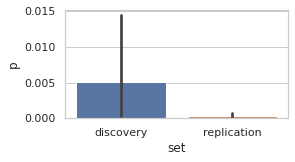

In [21]:
sns.barplot(x='set', y='p', data=plot_data)

### Plot all bootstrap cases: scatterplot of 'in-sample' vs. 'out-of-sample' r.

Text(0.5, 0, 'out-of-sample (r_pred)')

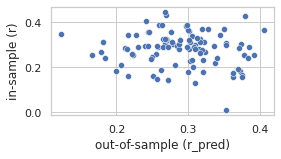

In [22]:
plot_data_wide = pd.DataFrame({
    'r_discovery_cv': r_discovery_cv,
    'r_replication': r_replication,
    'p_discovery_cv': p_discovery_cv,
    'p_replication': p_replication
})
sns.scatterplot(x='r_replication', y='r_discovery_cv', data=plot_data_wide)
plt.ylabel('in-sample (r)')
plt.xlabel('out-of-sample (r_pred)')

## Replicability
We compute replicability as ratio of cases where the replication sample gave significant predictions, given that the discovery sample gave significant predictions.

In [23]:
for alpha in [0.05, 0.01, 0.05, 0.001]:
    plot_data_wide['positive'] = False
    plot_data_wide.loc[plot_data_wide['p_discovery_cv']<alpha,'positive'] = True

    print('Replicability at alpha =', alpha, ':', (plot_data_wide.loc[plot_data_wide['p_discovery_cv']<alpha,'p_replication']<alpha).sum(), '%')

Replicability at alpha = 0.05 : 99 %
Replicability at alpha = 0.01 : 97 %
Replicability at alpha = 0.05 : 99 %
Replicability at alpha = 0.001 : 83 %


-------------------------------
# Replicability with n=500
Here we train one of the most straightforward models possible: a Ridge regression model.
No hyperparameter optimization, no dimensionality reduction, no feature scaling, we really keep it simple!

We define a workhorse function which:
- randomly samples the discovery and the replication datasets,
- creates cross-validated estimates of predictive performance within the discovery sample
- finalizes the model by fitting it to the whole discovery sample (overfits the discovery but not the replication sample)
- use it to predict the replication sample

We aggregate the results of `n_bootstrap`=100 bootstrap cases (run in parallel).

In [14]:
%%time

random_state = 42

clf = Ridge() # no hyperparameter optimization

n_bootstrap = 100
sample_size = 499

# nested cv
outer_cv = KFold(10, shuffle=True, random_state=random_state)

# loop for bootstrapped discovery and replication sets
def bootstrap_workhorse(random_state):
    X_discovery, X_replication, y_discovery, y_replication = train_test_split(X, y, train_size=sample_size, test_size=sample_size, shuffle=True, random_state=random_state)

    predicted_discovery_cv = cross_val_predict(estimator=clf, X=X_discovery, y=y_discovery, cv=outer_cv, n_jobs=1)
    r_disc_cv = np.corrcoef(predicted_discovery_cv, y_discovery)[0, 1]
    # Finalize on full discovery set
    final_model = clf.fit(X=X_discovery, y=y_discovery)

    # Test on replication set
    predicted_replication = final_model.predict(X=X_replication)
    r_rep = np.corrcoef(predicted_replication, y_replication)[0, 1]

    p_disc_cv = permutation_test(predicted_discovery_cv, y_discovery, method='approximate', num_rounds=10000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)
    p_rep = permutation_test(predicted_replication, y_replication, method='approximate', num_rounds=10000, func=lambda x, y: np.corrcoef(x, y)[1][0],seed=random_state)

    return r_disc_cv, r_rep, p_disc_cv, p_rep

rng = np.random.default_rng(random_state)
random_sates = rng.integers(np.iinfo(np.int32).max, size=n_bootstrap)

r_discovery_cv, r_replication, p_discovery_cv, p_replication = zip(
    *Parallel(n_jobs=-1)(
    delayed(bootstrap_workhorse)(seed) for seed in random_sates))


CPU times: user 278 ms, sys: 51.4 ms, total: 329 ms
Wall time: 59.9 s


### Now we plot the Pearson-correlation between predicted and observed, both in case of the discovery and replication sample:

r                                                        p  \
             count      mean       std       min       50%       max  count   
set                                                                           
discovery    100.0  0.291326  0.045040  0.173846  0.293389  0.385425  100.0   
replication  100.0  0.301492  0.026734  0.227583  0.303643  0.352574  100.0   

                                                             
                 mean           std     min     50%     max  
set                                                          
discovery    0.000102  1.406912e-05  0.0001  0.0001  0.0002  
replication  0.000100  5.448321e-20  0.0001  0.0001  0.0001

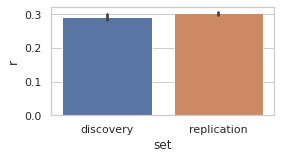

In [15]:
plot_data = pd.DataFrame({
    'r': np.concatenate((r_discovery_cv, r_replication)),
    'p': np.concatenate((p_discovery_cv, p_replication)),
    'set': np.concatenate((np.repeat('discovery', n_bootstrap), np.repeat('replication', n_bootstrap)))
})
sns.barplot(x='set', y='r', data=plot_data)
plot_data.groupby('set').describe(percentiles = [0.5])

### Let's plot the (permutation-based) p-values, too

<AxesSubplot:xlabel='set', ylabel='p'>

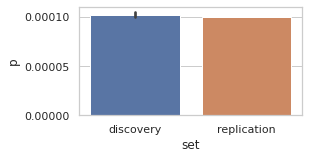

In [16]:
sns.barplot(x='set', y='p', data=plot_data)

### Plot all bootstrap cases: scatterplot of 'in-sample' vs. 'out-of-sample' r.

Text(0.5, 0, 'out-of-sample (r_pred)')

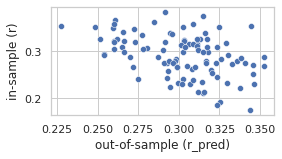

In [17]:
plot_data_wide = pd.DataFrame({
    'r_discovery_cv': r_discovery_cv,
    'r_replication': r_replication,
    'p_discovery_cv': p_discovery_cv,
    'p_replication': p_replication
})
sns.scatterplot(x='r_replication', y='r_discovery_cv', data=plot_data_wide)
plt.ylabel('in-sample (r)')
plt.xlabel('out-of-sample (r_pred)')

## Replicability
We compute replicability as ratio of cases where the replication sample gave significant predictions, given that the discovery sample gave significant predictions.

In [18]:
for alpha in [0.05, 0.01, 0.05, 0.001]:
    plot_data_wide['positive'] = False
    plot_data_wide.loc[plot_data_wide['p_discovery_cv']<alpha,'positive'] = True

    print('Replicability at alpha =', alpha, ':', (plot_data_wide.loc[plot_data_wide['p_discovery_cv']<alpha,'p_replication']<alpha).sum(), '%')

Replicability at alpha = 0.05 : 100 %
Replicability at alpha = 0.01 : 100 %
Replicability at alpha = 0.05 : 100 %
Replicability at alpha = 0.001 : 100 %
